In [1]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

/home/sergio/miniconda3/lib/python3.5/site-packages/deeptools/utilities.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/sergio/miniconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sergio/miniconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sergio/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sergio/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sergio/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    iol

In [2]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [3]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')

# Data loading

### Genome Wide mutations in TLX3

In [4]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

### RNA-expression table TLX3-vs-RAG

In [5]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# -- Pheno --
#A,B = 'TLX3','RAG'
#classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

### Enhancers from chromatin states

In [6]:
## == Enhancers 
enh = pb.BedTool(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM.bed'))
enh_df = enh.to_dataframe()

# Enh to genes table
enh2gn = pd.read_table(join(DATADIR,'tracks/Enhancers_RAG_enh2genes.txt'), 
                        header=1, 
                        names=['enhancers','gene_name'])
# Gene to enh table
gn2enh = pd.read_table(join(DATADIR,'tracks/Enhancers_RAG_genes2enh.txt'), 
                        header=1, 
                        names=['gene_name','enhancers'])


### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [7]:
# Regulatory Potentials
# rpt  =  pd.read_table(join(RP,'RAG_TLX_TAP_relativeRP_mm10mm9.txt'))

# # -- transform
# rp = rpt.sort_values('lgFC_TLXvsRAG', axis=0, ascending=False)
# rp.drop_duplicates(subset='gene_name', inplace=True)


# Ap,Bp = 'TLX_rel_RP','RAG_rel_RP'
# cols = ['gene_name', Ap, Bp]

# rp = rp[cols]
# rp = rp.set_index(keys=rp.columns[0])


### Annotations: genes, tss, T-all oncogenes etc.

In [8]:
# Load T-ALL ocnogenes
tall = erl.read_gmt(join(DATADIR,'gene_lists/Cancermine/T-ALL.gmt')) 
df_mut = pd.read_csv(join(DATADIR,'gene_lists/COSMIC/Genes_mutation_HUMAN_Acute-lymphoblastic-leukaemia.csv'))

df_mut['Gname'] = df_mut['Gene name'].apply(lambda x: x.split('_')[0])

tall_onc = tall['T-ALL all']
tall_mut = list(df_mut['Gname'].unique())

# Load genes body regions
genes = pb.BedTool(join(DATADIR,'tracks/annot_tracks/references/mm9/mm9.refGene.bed'))


# Story ONE: Active in RAG only enhancers and active genes 

![title](im/Story1RAG.png)

## Active enhacers in RAG not in TLX3 based on H4K27ac potential

In [9]:
pad = 3e3 # 3k padding 

#tlx_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/TAP_H3K27ac_mm9.bw')
#rag_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/RAG_H3K27ac_mm9.bw')


#enh_27ac_tlx = emm.bigWig2bed_pot(tlx_27ac,enh,'mm9',pad=pad)

tlx_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM_TLX3_H3K27ac.csv'), index_col=0)
rag_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM_RAG_H3K27ac.csv'), index_col=0)

tlx_27ac.rename(columns={'RP':'RP_tlx'}, inplace=True)

rag_27ac.rename(columns={'RP':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

In [10]:
# PolII in TLX3 signal on enhancers for verification
# tlx_polII = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_TLX3_PolII.csv'), index_col=0)

# tlx_polII.rename(columns={'RP':'RP_tlx_polII'}, inplace=True)
# tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

# tlx_rag_27ac_polII = pd.concat([tlx_27ac,
#                                 rag_27ac.drop(['chrom','start','end', 'name'], axis=1),
#                                 tlx_polII.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

## Scatter plot of enhacer's activity TLX3-vs-RAG: color is PolII signal strength

In [11]:
# dpc = tlx_rag_27ac_polII.copy()#head(8000)

# f, ax = plt.subplots(figsize=(6.5, 6.5))
# sns.scatterplot(x = log2p1(dpc['RP_rag']), 
#                     y = log2p1(dpc['RP_tlx']), 
#                     hue=log2p1(dpc['RP_tlx_polII']), 
#                     data=dpc, 
#                     ax=ax, 
#                     palette='jet',#'gnuplot',#'jet',#'RdBu_r', 
#                     linewidth=0, 
#                     s=3.4)

# ax.axis('equal')
# ax.axis('tight')

## Scatter plot of enhacer's activity TLX3-vs-RAG: color logFoldChange

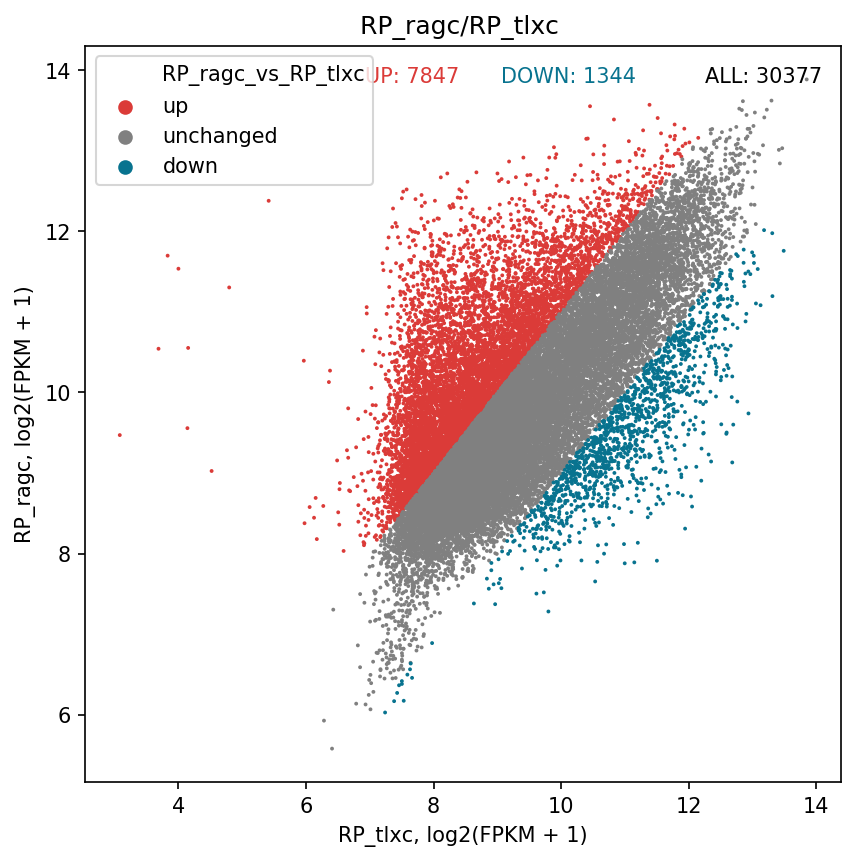

In [12]:
## Scatter of 27ac potential on enhancers

Ap,Bp = 'RP_rag','RP_tlx'
cols = ['name', Ap, Bp]

tlx_rag_27ac_s = tlx_rag_27ac[cols]

tlx_rag_27ac_s = tlx_rag_27ac_s.set_index(keys=tlx_rag_27ac_s.columns[0])

tlx_rag_27ac_s = tlx_rag_27ac_s.apply(pd.to_numeric)

Ac= Ap+'c'
Bc= Bp+'c'

classes=[Ac,Bc]
#df_mean= tlx_rag_27ac_s.groupby(by=classes, axis=1).mean()

df=rn.scatter_n(tlx_rag_27ac_s, Ac, Bc,classes=classes)

In [13]:
## UP regulated by H3K27ac enhancers
tlx_rag_27ac_FC=df[0]


### genes associate with top UP enhancers
tlx_vs_rag_top = list(tlx_rag_27ac_FC.index)
tlx_vs_rag_topGenes = emm.gene_enh(tlx_vs_rag_top,enh2gn)


## UP/DOWN genes regulated by activated in RAG enhacers  

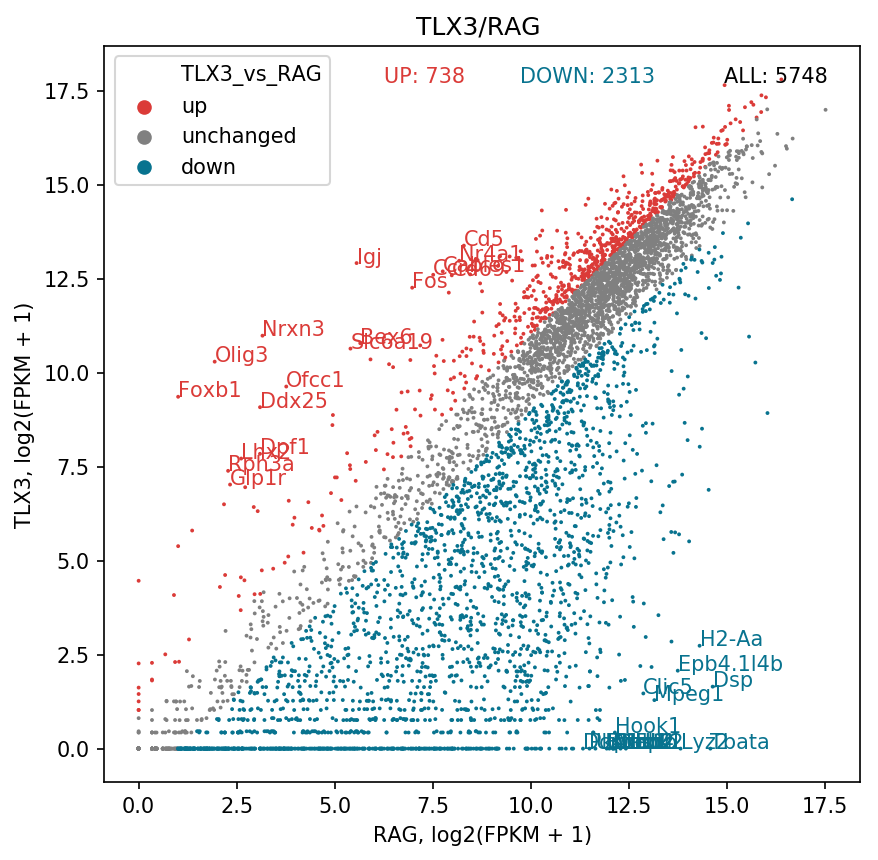

In [14]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(tlx_vs_rag_topGenes)], A, B,classes=classes, n_top=18)

In [15]:
## enhancers from UP genes
up_genes = list(tmp[1].index)
up_gene_enh =  emm.enh_gene(up_genes,gn2enh)

In [16]:
print('Up regulated enhancers = ',len(tlx_vs_rag_top))
print('Enhancers of up-regulated genes  = ',len(up_gene_enh))

Up regulated enhancers =  7847
Enhancers of up-regulated genes  =  11325


In [17]:
# Up enhancers with up genes
up_enh_up_genes = list(set(tlx_vs_rag_top) & set(up_gene_enh))
print('Up enhancers of up-regulated genes  = ',len(up_enh_up_genes))

Up enhancers of up-regulated genes  =  4968


In [18]:
# Load TLX3 peaks
tlx_pk = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_pk = tlx_pk.slop(b=sl, genome='mm9')

enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

enh_up_up_tlx = (enh_up_up_bd + tlx_pk).to_dataframe()

In [19]:
# Finally
# associated genes
enh_up_up_tlx_genes = emm.gene_enh(list(enh_up_up_tlx['name']),enh2gn)

print('Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx_genes))
print('UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx))

Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  175
UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  98


## UP regulated final genes

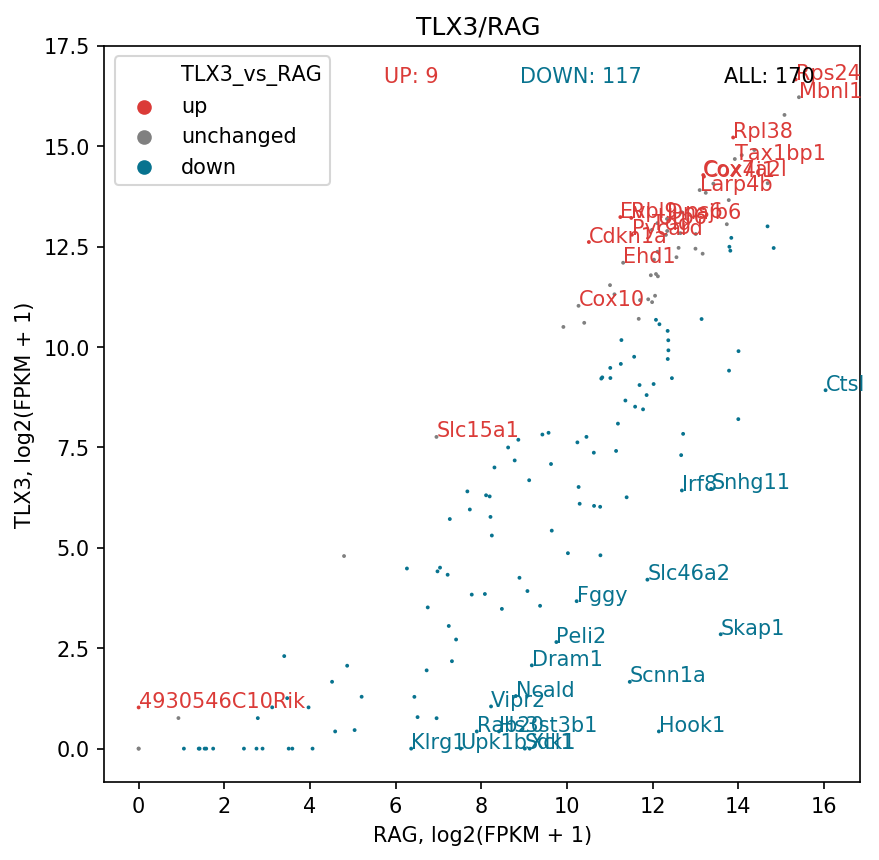

In [20]:
## Expression of last genes

# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(enh_up_up_tlx_genes)], A, B,classes=classes, n_top=18)

## Enrichment of final 117 genes

In [21]:
fin_up_genes = list(tmp[1].index)

## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'NCI-60_Cancer_Cell_Lines',
       ]

FIN_up_genes = [x.upper() for x in fin_up_genes]

enr = erl.enrich_gs(FIN_up_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 923
GO_Cellular_Component_2018 75
GO_Molecular_Function_2018 190
KEGG_2016 115
Reactome_2016 216
Cancer_Cell_Line_Encyclopedia 630
NCI-60_Cancer_Cell_Lines 75


In [22]:
# Make additional calculation on existing columns for visualization
enr.loc[:,'ass_genes_percnt'] = 100*enr.loc[:,'num_list']/enr.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[(enr['p-Val']<0.001)&(enr['ass_genes_percnt']>8)]



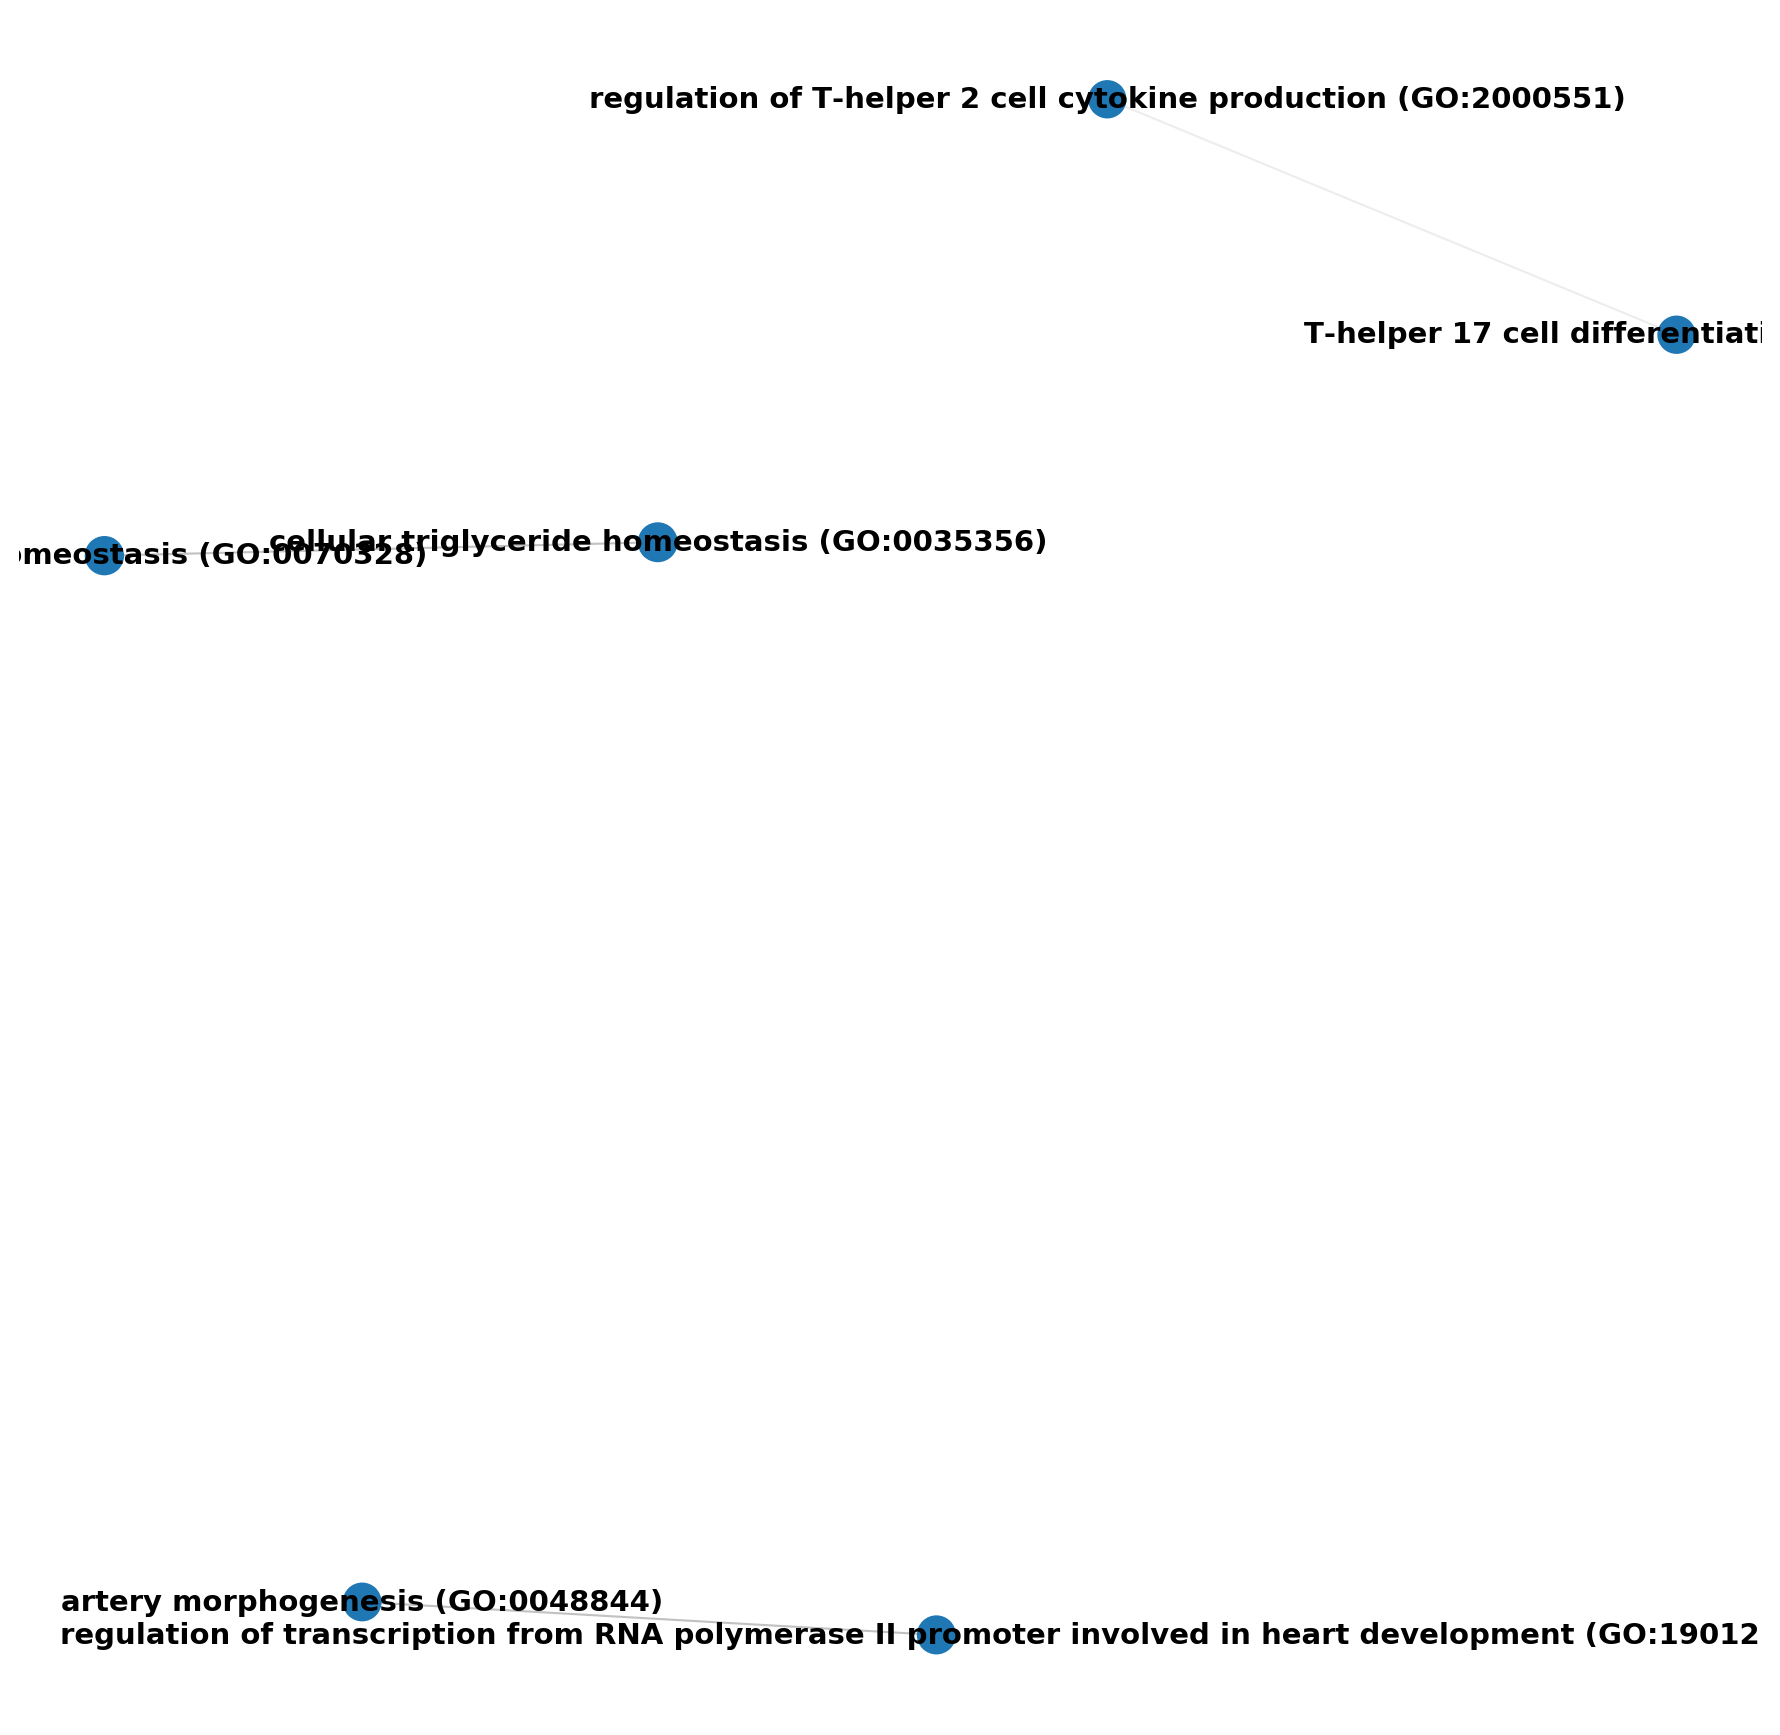

In [23]:
## Cluster: this calculate and add cluster number column
#enr_a = erl.cluster(FIN_up_genes,enr_a)
cm = 'tab20'
G, enr_c, nt_b =erl.make_graph(FIN_up_genes, enr_a, kappa=0.4)

erl.draw_graph(G)

Text(0.5,1,'UP genes regulated by UP enhancers with high Tlx3 peaks')

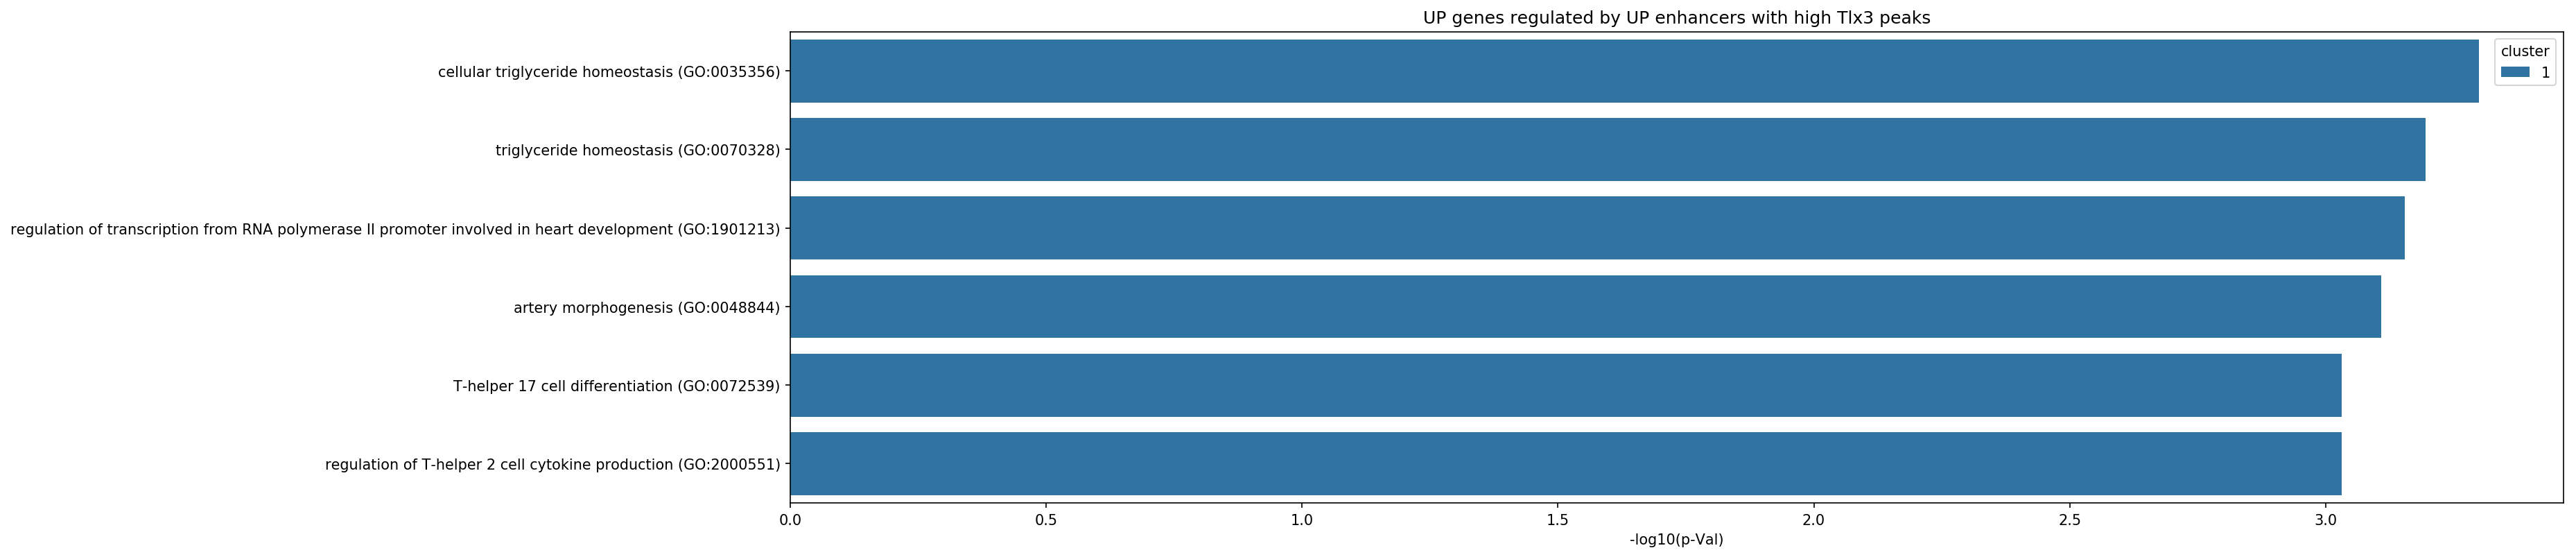

In [24]:
# --- Plot ---
# use consistent discrete palette

enr_c.sort_values('cluster', axis=0, inplace = True)
ds = enr_c.head(20)

f, ax = plt.subplots(figsize=(22, 6))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('UP genes regulated by UP enhancers with high Tlx3 peaks')



## Calculate independent distance on selected gene sets (terms)

In [25]:
# Calculate independent distance on selected gene sets (terms)
enr_c = erl.cluster_jacc(enr_c)


## Double clustering: close terms in both categories

In [26]:
enr_grp = enr_c.groupby(by=['cluster','cluster_jacc'],axis=0)

# Fucntion takes double cluster and return common genes  

def get_cluster(cl, enr_grp):
    enr_clust = enr_a.loc[enr_grp.groups[cl]]
    gn_clust = set(enr_clust.iloc[0]['genes'])
    for i in range(len(enr_clust)):
        gn_clust = gn_clust & set(enr_clust.iloc[i]['genes'])
    
    return gn_clust

In [27]:
# Print clustes and common genes 


# Terms in cluster
for k in enr_grp.groups.keys():
    print(k)
    for i in list(enr_grp.groups[k]):
        print('\t',i)

#'num_terms :',len(list(enr_grp.groups[k]))


(1, 1)
	 cellular triglyceride homeostasis (GO:0035356)
	 triglyceride homeostasis (GO:0070328)
	 regulation of transcription from RNA polymerase II promoter involved in heart development (GO:1901213)
	 artery morphogenesis (GO:0048844)
	 T-helper 17 cell differentiation (GO:0072539)
	 regulation of T-helper 2 cell cytokine production (GO:2000551)


In [28]:
# Genes common in clusters 
for k in enr_grp.groups.keys():
    print(k, get_cluster(k, enr_grp))

(1, 1) set()


In [29]:
# Fucntion takes double cluster and return common genes in terms  

def get_cluster_terms(cl, enr_grp):
    enr_clust = enr_a.loc[enr_grp.groups[cl]]
    gn_clust = set(enr_clust.iloc[0]['term_genes'])
    for i in range(len(enr_clust)):
        gn_clust = gn_clust & set(enr_clust.iloc[i]['term_genes'])
    
    return gn_clust

In [30]:
#tm = enr_a.loc[enr_grp.groups[(7,4)]]

# Story TWO: Active in TLX3 only enhancers with mutation and active genes 

![title](im/Story2RAG.png)

## Intersect mutation in TLX3 with active enhancers from privious analysis

In [31]:
## Up enhancers with up genes
# up_enh_up_genes -- list of enhancers
# --| enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
# --| enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

# enh_up_up_bd  --- bed file of enhancers
print('Up enhancers of up-regulated genes  = ',len(enh_up_up_bd))


# tlx_gn -- variants in TLX3


Up enhancers of up-regulated genes  =  4968


In [32]:
# Variant inside active enhancers

enh_mut_tlx = emm.bed_variants(tlx_gn,enh_up_up_bd)
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx))

Variants from TLX3 WGS in active enhacers =  3524


In [33]:
# Save only if new analysis done
enh_mut_tlx.saveas(join(WGS,'Ehn_RAG_Active_TLX3_mut.vcf'))

<BedTool(/home/sergio/Res_CIML/TLX3_project/data/tracks/WGS-WES/Germline/Ehn_RAG_Active_TLX3_mut.vcf)>

In [34]:
# Load table
import allel
enh_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Ehn_RAG_Active_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

In [35]:
enh_mut_tlx_tb_fltr = enh_mut_tlx_tb[enh_mut_tlx_tb['FILTER_PASS']==True]

In [36]:
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx_tb))
print('Variants from TLX3 WGS in active enhacers PASS filter = ', len(enh_mut_tlx_tb_fltr))

Variants from TLX3 WGS in active enhacers =  3524
Variants from TLX3 WGS in active enhacers PASS filter =  2678


In [37]:
#enh_mut_tlx_tb[['FILTER_map','FILTER_PASS','FILTER_mrd20','FILTER_LowQual','FILTER_mrd10','FILTER_mrd30']].head(40)
#tnm = plt.hist(enh_mut_tlx_tb['REF'].apply(len), bins=40)
#tnm = plt.hist(enh_mut_tlx_tb['ALT_1'].apply(len), bins=40)

## Motifs around mutations in active enhancers

In [38]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']


In [39]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [40]:
# mut_tb = enh_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Enhancers_RAG_Motifs_scores.csv'))

In [41]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Enhancers_RAG_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [42]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [43]:
mut_tb_fltr_srt.head(20)

,CHROM,POS,REF,ALT_1,is_snp,REF_Prot,REF_model,REF_score_ref,REF_score_alt,ALT_Prot,ALT_model,ALT_score_ref,ALT_score_alt,REF_score_diff
1344,chr15,58834538,T,C,True,Rfx7,D00072.001,33.357822,1.262218,Klf9,D00026.001,3.404741,3.979531,32.095604
3476,chr9,103373665,A,C,True,Sox6,D00039.001,29.214870,1.121617,Foxc2,D00061.001,4.474813,3.646667,28.093253
1780,chr17,31870432,CA,C,False,Tbx3,D00018.001,19.754713,0.238770,Gbx1,D00414.003,1.168410,1.985958,19.515943
1106,chr13,64511939,TCCCCCCCC,T,False,Znf740,D00083.001,19.278561,-0.074207,Egr3,D00058.001,5.968520,2.003879,19.352768
250,chr1,36628940,C,CTG,False,Znf740,D00083.001,19.221281,0.575953,Zfp202,D00047.001,9.874022,4.277870,18.645328
1781,chr17,31870434,C,T,True,Tbx3,D00018.001,18.376518,-0.001189,Nr2f6,D00030.004,0.631192,0.808165,18.377707
2533,chr5,100486618,TCCCCCCCCC,T,False,Znf740,D00083.001,21.936911,3.737957,Egr3,D00058.001,6.223981,4.705463,18.198954
1681,chr17,30268772,T,G,True,Sox6,D00039.001,18.329845,0.294959,Rhox11,D00620.003,0.704804,1.149191,18.034886
2661,chr6,115711407,T,G,True,Sox6,D00039.001,17.896835,0.255039,Foxk1,D00402.001,0.022918,0.664287,17.641796
1901,chr17,34775897,A,T,True,Sox6,D00039.001,19.621002,3.179841,Foxc2,D00061.001,2.567387,3.997139,16.441161


## Find enhacers with TFS changes and associated genes

In [44]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()
mut_tf_enh = enh.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_enh.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_enh.rename(columns={'thickEnd':'protein'}, inplace=True)

genes_mut_tf_enh = emm.gene_enh(list(mut_tf_enh['name']),enh2gn)

In [45]:
print('Genes with enhacers with TFBS cahnges = ', len(genes_mut_tf_enh)) 

Genes with enhacers with TFBS cahnges =  405


In [46]:
print('Genes with enhacers with TFBS cahnges:\n', genes_mut_tf_enh) 

Genes with enhacers with TFBS cahnges:
 ['Gtdc1', 'Fam49a', 'Zeb2', 'Rab44', 'Erp27', 'Foxp4', 'Chga', 'Jmy', 'Cdca7l', 'H2-Eb1', 'Serinc5', 'Gdf6', 'Htra3', 'Uggt1', 'Cdc14b', 'C6', 'Supt3', 'Iqgap2', 'Pgpep1l', 'Tulp3', 'Gm6685', 'Rhbdf2', 'Cdkn1a', 'Rbbp8', 'Afap1', 'Arid5b', 'Trf', 'Fzd9', 'Gse1', 'Ankrd60', 'Tead4', 'Pram1', 'Creg2', 'Pdzrn4', 'Fam92b', 'Cdk20', 'Frrs1l', 'Chsy1', 'Slc25a29', 'Ccdc90b', 'Clic5', 'Myl1', 'Tnp1', 'Pld4', '9930013L23Rik', 'Fer1l6', 'Themis3', 'Abca1', 'Cysltr2', 'Ift122', 'Hlcs', 'Arap1', 'Unc93b1', 'Rfx8', 'Klf9', 'Synpo2', '4833420G17Rik', 'Art3', 'Glrx', 'Abra', 'Mctp1', 'Cep72', 'Itprip', 'Alk', 'Pcif1', 'Cxcl10', 'Acacb', 'Il18bp', 'A530021J07Rik', 'Amph', 'Rad18', 'Btbd6', 'Rab22a', 'Sim2', 'Eif3h', 'Kank1', 'Epas1', 'Rho', 'Gga1', 'Thap4', 'Enpp4', 'Syt17', 'Adra1b', 'Stard3nl', 'Tppp', 'Hsph1', 'Cacng1', '4933400A11Rik', 'Ttpa', 'Abcg1', 'Wnt11', '2900026A02Rik', 'Pdcd4', 'Cnot11', 'Ncapg2', 'Gm9874', 'Spon1', 'Trpm3', 'Tpcn2', 'Ankrd32', 'Is

### Genes enrichments

In [47]:
genes_mut_tf_enh = [x.upper() for x in genes_mut_tf_enh]

enr_genes_mut_tf_enh = erl.enrich_gs(genes_mut_tf_enh,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 2006
GO_Cellular_Component_2018 182
GO_Molecular_Function_2018 429
KEGG_2016 217
Reactome_2016 606
Cancer_Cell_Line_Encyclopedia 874
NCI-60_Cancer_Cell_Lines 92


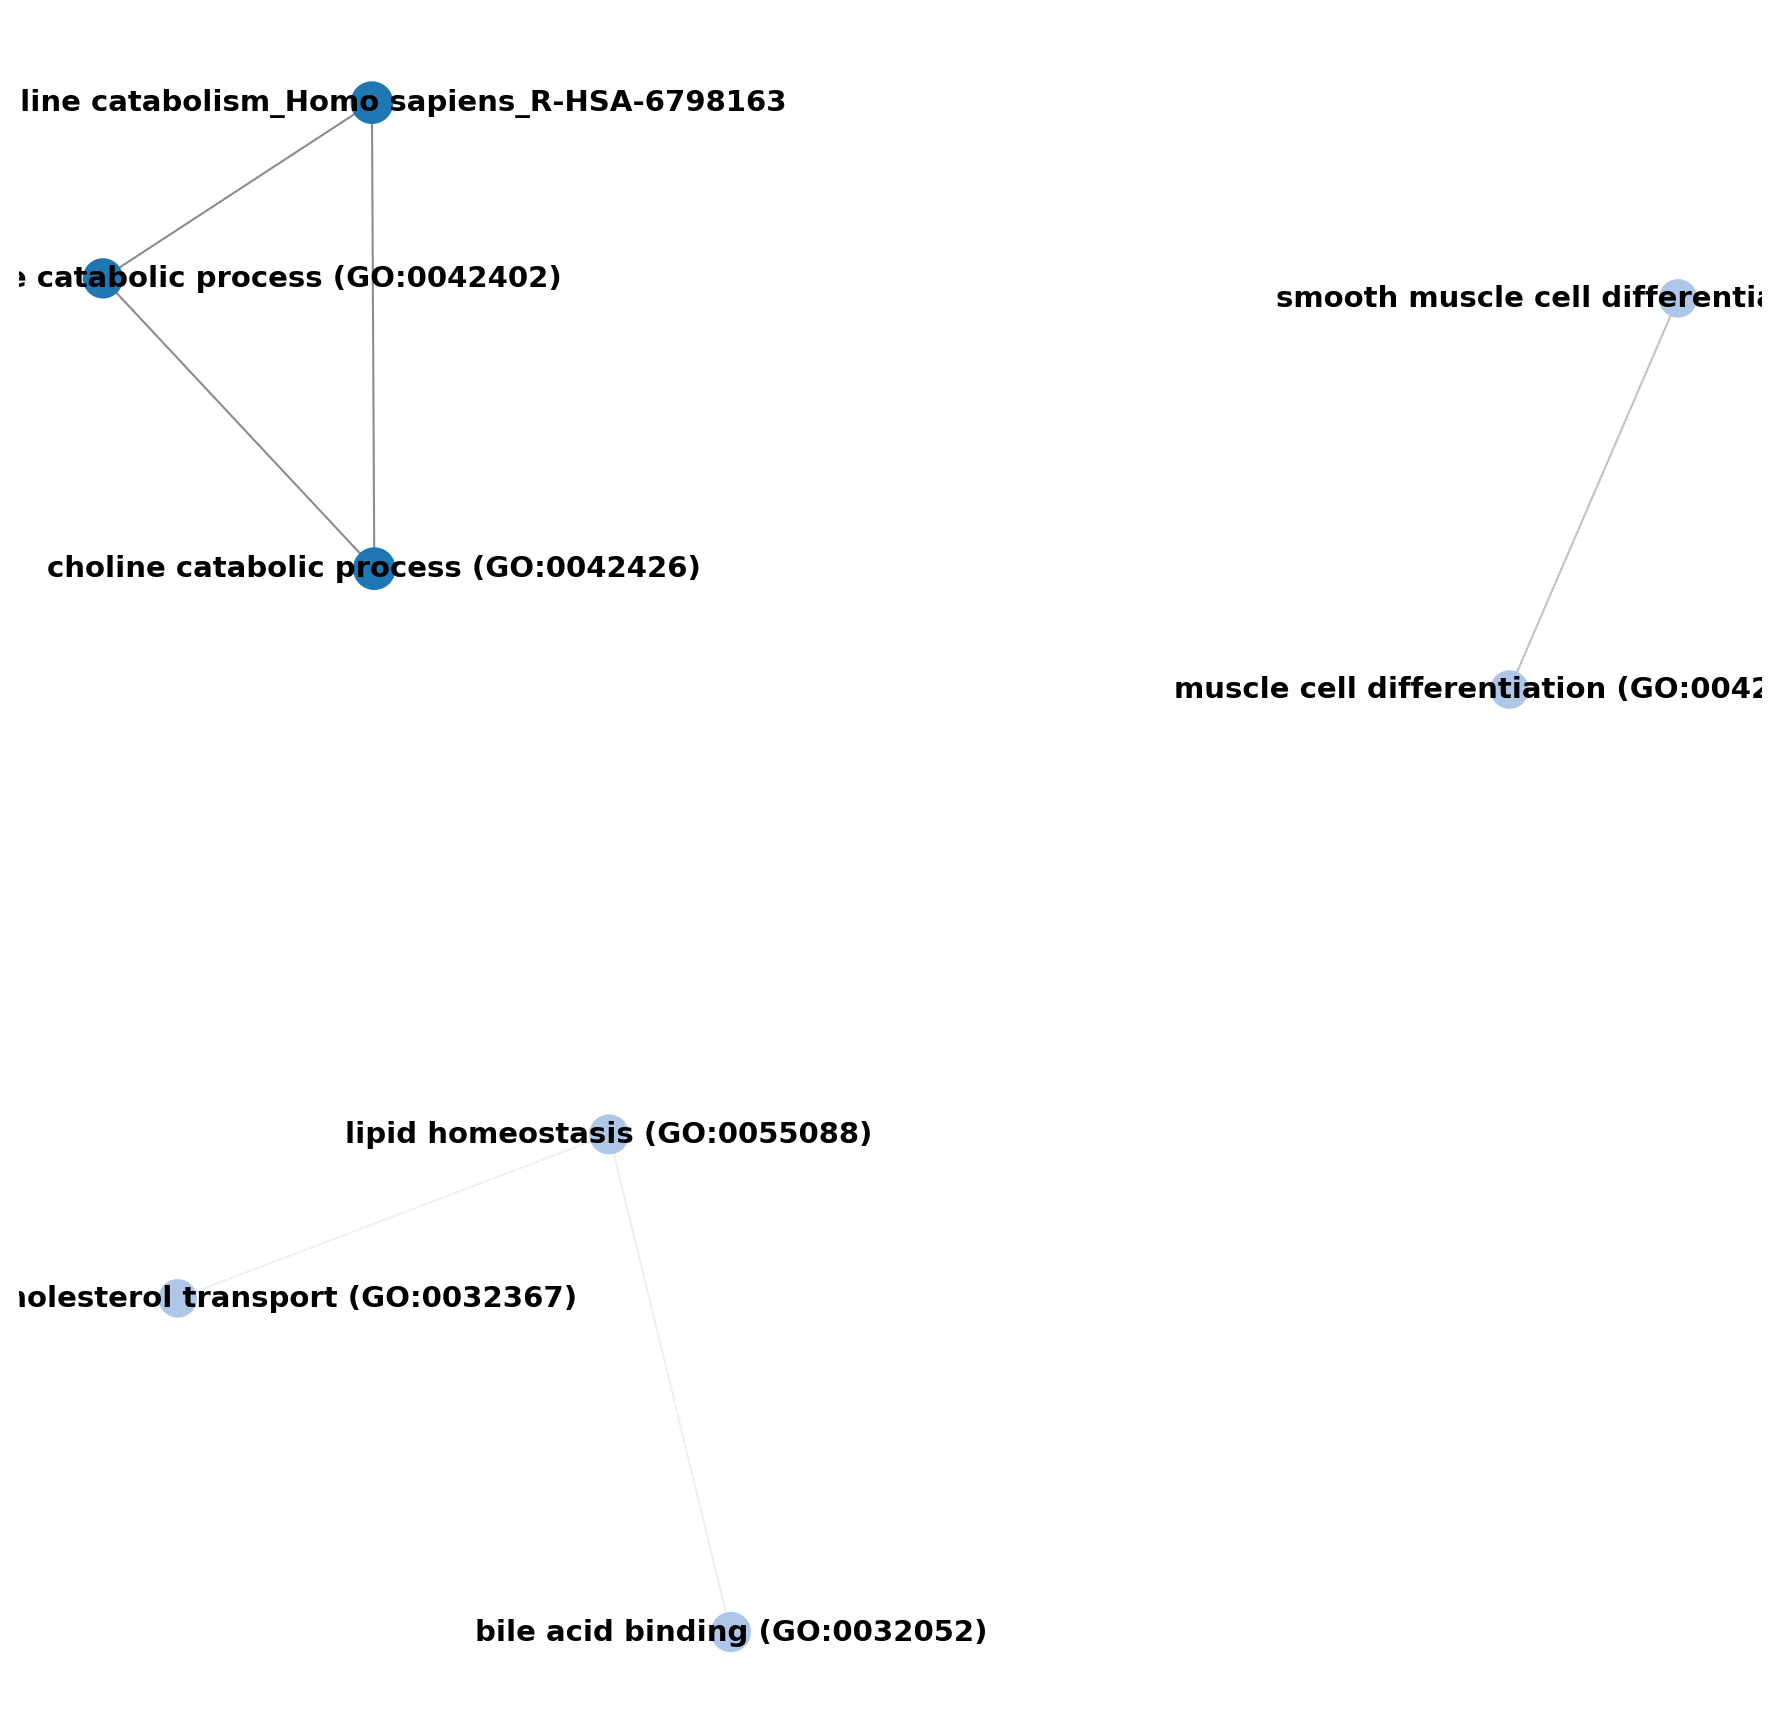

In [48]:
# Make additional calculation on existing columns for visualization
enr_genes_mut_tf_enh.loc[:,'ass_genes_percnt'] = 100*enr_genes_mut_tf_enh.loc[:,'num_list']/enr_genes_mut_tf_enh.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_genes_mut_tf_enh = enr_genes_mut_tf_enh[(enr_genes_mut_tf_enh['p-Val']<0.001)&(enr_genes_mut_tf_enh['ass_genes_percnt']>5)]

## Cluster: this calculate and add cluster number column
#enr_genes_mut_tf_enh = erl.cluster(genes_mut_tf_enh,enr_genes_mut_tf_enh)
G, enr_genes_mut_tf_enh_c, nt_b =erl.make_graph(genes_mut_tf_enh, 
                                                    enr_genes_mut_tf_enh, 
                                                    kappa=0.4)
erl.draw_graph(G)



In [49]:
#enr_genes_mut_tf_enh

Text(0.5,1,'Genes for UP enhancers with TF mutations')

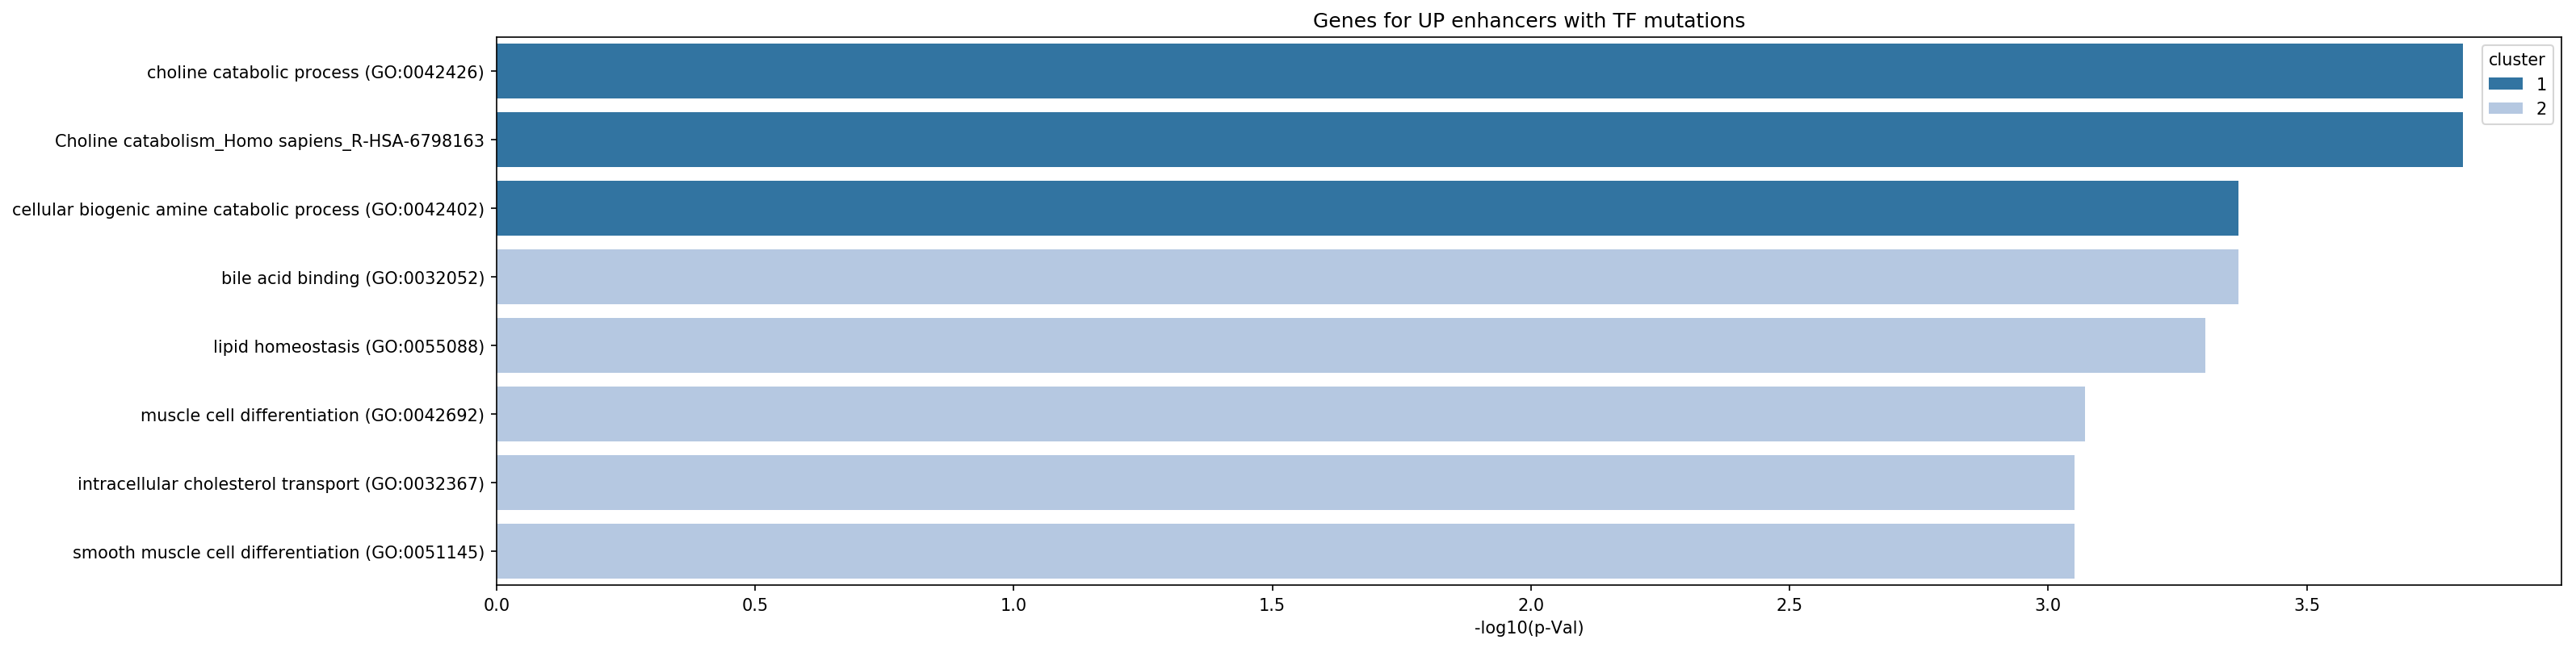

In [50]:
enr_genes_mut_tf_enh_c.sort_values('cluster', axis=0, inplace = True)
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_genes_mut_tf_enh_c.head(10)

f, ax = plt.subplots(figsize=(22, 6))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('Genes for UP enhancers with TF mutations')

